In [1]:
import os
import gc
import glob
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import climpred
from climpred import HindcastEnsemble
from functools import partial
import xarray as xr
from eofs.xarray import Eof
import xesmf as xe
import xskillscore as xs
import readnc_tools as rd
import readnc2_tools as rd2
import plot_tools as pt

path_temp="/cnrm/pastel/DATA/REF/era5/ncdf/daily/"
path_snow="/cnrm/pastel/USERS/ardilouzec/obs/era5_land/"
lat_lims = [30,90]

<frozen importlib._bootstrap>:219: UserWarning: PROJ 8+ is required. Current version: 7.2.0


In [31]:
ref='era5'
variables=['t2m']
min_lat=40 ; max_lat=53; min_lon=110; max_lon=140
temp=rd.read_ref(path_temp,variables,ref)
temp=temp.groupby("time.dayofyear")-temp.groupby("time.dayofyear").mean("time")
temp=temp.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)).mean(["lat","lon"]).compute()

In [3]:
ref='era5land'
variables=['sd']
sn=rd.read_ref(path_snow,variables,ref)
sn=sn.groupby("time.dayofyear")-sn.groupby("time.dayofyear").mean("time")

In [4]:
sn=sn.reindex({"time":temp.time}).compute()

In [13]:
sn=sn.rename({'sd':'snow'})

Text(0.5, 1.0, 'Standard deviation of Feb-to-May ERA5-Land snow cover anomalies (snow depth water equivalent)')

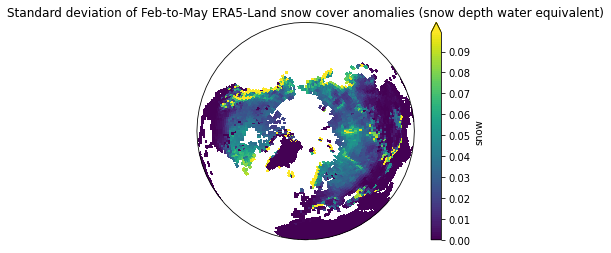

In [14]:
sn.snow.std(dim='time').sel(lat=slice(0,90)).plot(levels=[np.round(x,3) for x in np.arange(0,0.1,0.001)],transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.Orthographic(central_longitude=0, central_latitude=90))
                                            )
plt.title("Standard deviation of Feb-to-May ERA5-Land snow cover anomalies (snow depth water equivalent)")

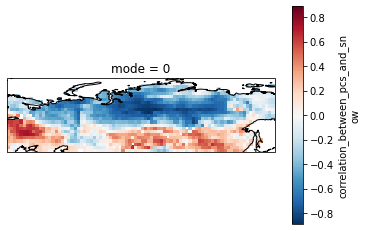

In [81]:
snmonth=sn.where(((sn.time.dt.month==2)&(sn.time.dt.day>=17))|((sn.time.dt.month==3)&(sn.time.dt.day<=18))).dropna(dim='time',how='all')
sneof=snmonth.snow.sel(lat=slice(45,78),lon=slice(25,150))
coslat = np.cos(np.deg2rad(sneof.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver=Eof(sneof,weights=wgts)
eofs=solver.eofsAsCorrelation(neofs=3)
p=eofs[0].plot(transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
#pcs=solver.pcs(npcs=3)
p.axes.coastlines()

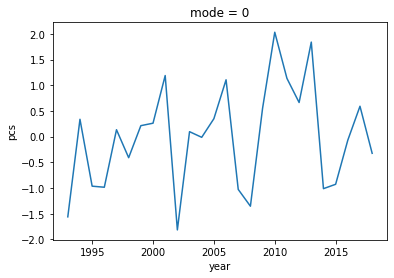

In [37]:
pc1=solver.pcs(npcs=3, pcscaling=1)
a=xr.DataArray(pc1[:,0],dims=['time'])
a.groupby('time.year').mean('time').plot()

In [18]:
ref='era5land'
variables=['sd']
snfull=rd.read_ref(path_snow,variables,ref).compute()
snfull=snfull.rename({'sd':'snow'})

Text(0.5, 1.0, 'Mean snow evolution btwn 25 Feb.and 18 March')

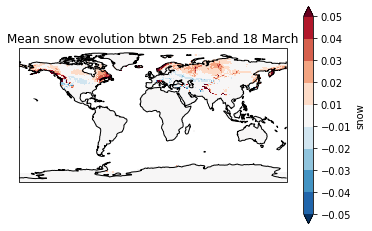

In [35]:
levels = [np.round(x,2) for x in np.arange(-0.05,0.06,0.01) ]
levels.remove(0)
g=snfull.where((snfull.time.dt.month==3) & (snfull.time.dt.day==18)).dropna(dim='time',how='all')
f=snfull.where((snfull.time.dt.month==2) & (snfull.time.dt.day==25)).dropna(dim='time',how='all')
#a.sd.mean('time').plot(levels=[np.round(x,2) for x in np.arange(0,0.55,0.05)])
p=(g.snow.mean('time')-f.snow.mean('time')).plot(levels=levels,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
p.axes.coastlines()
plt.title("Mean snow evolution btwn 25 Feb.and 18 March")

In [32]:
#daily emperature anomalies over the red box.
print(temp.t2m.time)
print(sn.snow.time)

<xarray.DataArray 'time' (time: 9496)>
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
<xarray.DataArray 'time' (time: 9496)>
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
    dayofyear  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan


In [34]:
# we compute 7-day rolling mean for temperature (weekly anomalies) but nor for snow (to comply with subseasonal forecast context)
#snow=sn.rolling(time=7).mean().dropna(dim='time',how='all')
temp1=temp.rolling(time=30).mean().dropna(dim='time')
temp2=temp.rolling(time=7).mean().dropna(dim='time')
print(temp1.time)

<xarray.DataArray 'time' (time: 9467)>
array(['1993-01-30T00:00:00.000000000', '1993-01-31T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1993-01-30 1993-01-31 ... 2018-12-31
    dayofyear  (time) int64 30 31 32 33 34 35 36 ... 359 360 361 362 363 364 365


In [39]:
# Attempt to regress temperature onto prior snow cover. I dropped it, I am not sure I understand the results
#snow.coords['temp']=('time',), temp.t2m.values
#snow=snow.swap_dims({'temp':'time'})
#coeffs = snow.polyfit('temp', deg=1,full='True')
#coeffs.sd_polyfit_coefficients[0,:,:].sel(lat=slice(30,75), lon=slice(90,150)).plot()

<xarray.DataArray 'pcs' (time: 786)>
array([-1.64786005e+00, -1.65283930e+00, -1.65499377e+00, -1.64061165e+00,
       -1.62302446e+00, -1.60994756e+00, -1.58834529e+00, -1.56348073e+00,
       -1.55875087e+00, -1.54836535e+00, -1.52330589e+00, -1.50254309e+00,
       -1.50287104e+00, -1.49936354e+00, -1.48530602e+00, -1.48526299e+00,
       -1.52110302e+00, -1.54138935e+00, -1.53367341e+00, -1.52225888e+00,
       -1.51633871e+00, -1.52146733e+00, -1.54415166e+00, -1.55170810e+00,
       -1.54543865e+00, -1.54108942e+00, -1.53855586e+00, -1.57300353e+00,
       -1.61848199e+00, -1.68156147e+00,  1.30760029e-01,  1.38638139e-01,
        1.56178966e-01,  1.61086902e-01,  1.75396487e-01,  1.90901920e-01,
        2.20300689e-01,  2.42721975e-01,  2.63212085e-01,  2.62312263e-01,
        2.64329195e-01,  2.69269794e-01,  2.98066348e-01,  3.25126469e-01,
        3.46788228e-01,  3.86121750e-01,  4.23074573e-01,  4.47161406e-01,
        4.63943243e-01,  4.95028615e-01,  5.14792681e-01,  5.05294859e-01,
        4.76464212e-01,  4.48346913e-01,  4.19988453e-01,  4.14910078e-01,
        4.05492097e-01,  4.16449815e-01,  4.32474315e-01,  4.48405504e-01,
       -7.35189736e-01, -7.43964732e-01, -7.59645164e-01, -7.83076108e-01,
       -7.97921896e-01, -8.05513084e-01, -8.12923253e-01, -8.31060946e-01,
       -8.29036057e-01, -8.42591465e-01, -8.76603484e-01, -8.89999747e-01,
       -9.05474246e-01, -9.49815571e-01, -1.00963867e+00, -1.05162859e+00,
       -1.07501316e+00, -1.08079088e+00, -1.11375010e+00, -1.15056276e+00,
...
       -1.59171686e-01, -1.45618796e-01, -1.17394350e-01, -1.07993208e-01,
       -7.14718774e-02, -3.96532267e-02, -3.20427231e-02, -3.51065323e-02,
       -4.54383008e-02, -5.44983558e-02, -5.14718965e-02, -5.82711995e-02,
       -6.25181422e-02, -5.50846197e-02, -5.79375103e-02, -9.06758755e-02,
       -1.27647728e-01, -1.47676572e-01,  9.96496141e-01,  1.00149262e+00,
        9.70727086e-01,  9.54595149e-01,  9.20073628e-01,  8.91220927e-01,
        8.62881720e-01,  8.30462813e-01,  7.97969520e-01,  7.73140907e-01,
        7.55609572e-01,  7.20116735e-01,  6.82326794e-01,  6.45783961e-01,
        6.18247628e-01,  5.68022609e-01,  5.43353319e-01,  5.03059089e-01,
        4.69660282e-01,  4.20467973e-01,  4.11157340e-01,  3.85188311e-01,
        3.58780771e-01,  3.19340229e-01,  2.75760263e-01,  2.41960555e-01,
        2.27108285e-01,  2.16957673e-01,  2.06132025e-01,  1.96769610e-01,
       -5.24228752e-01, -5.21340907e-01, -5.20558000e-01, -5.26485026e-01,
       -5.26054919e-01, -5.21004200e-01, -5.10334313e-01, -4.89686310e-01,
       -4.56390202e-01, -4.35164690e-01, -4.17474061e-01, -4.03305113e-01,
       -3.78307223e-01, -3.30882192e-01, -3.01082700e-01, -2.49964193e-01,
       -2.18692407e-01, -2.14148641e-01, -2.36147746e-01, -2.32255504e-01,
       -2.18909249e-01, -1.99287042e-01, -1.59440190e-01, -1.22121423e-01,
       -1.14821211e-01, -1.57438785e-01, -1.82391927e-01, -1.85194314e-01,
       -1.89769804e-01, -1.78284794e-01], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1993-02-17 1993-02-18 ... 2018-03-18
    mode       int64 0
    dayofyear  (time) float64 48.0 49.0 50.0 51.0 52.0 ... 74.0 75.0 76.0 77.0

Text(0.5, 1.0, 'Correlation=-0.44')

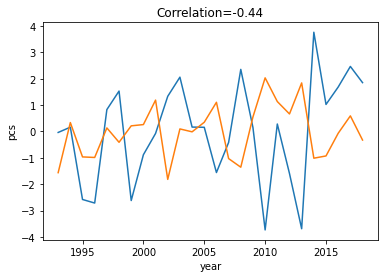

In [56]:
#we align the temperature at week 4 (e.g. 7-day rolling mean 25 days later) and subsample the dates in order to match the snow dates
#test_temp=temp.shift(time=-25).reindex({'time':sn.time})
temp1=temp1.where((temp1.time.dt.month==4)&(temp1.time.dt.day==15))
#we correlate yearly averages of the Principal component time series of EOF1 and the temperature index
c=xr.corr(temp1.groupby('time.year').mean('time').t2m,a.groupby('time.year').mean('time'))
temp1.groupby('time.year').mean('time').t2m.plot()
a.groupby('time.year').mean('time').plot()
plt.title("Correlation="+str(np.round(c.values,2)))

Text(0.5, 1.0, 'Correlation=-0.54')

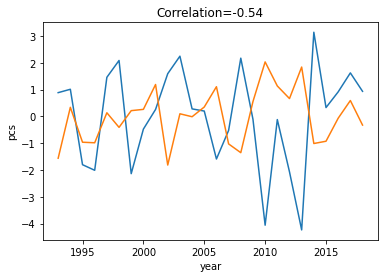

In [72]:
#Same as above but after linearly detrending temperature time series
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
detrended_temp=detrend_dim(da=temp1.groupby('time.year').mean('time').t2m,dim='year')
#we correlate yearly averages of the Principal component time series of EOF1 and the temperature index
c=xr.corr(detrended_temp,a.groupby('time.year').mean('time'))
detrended.plot()
a.groupby('time.year').mean('time').plot()
plt.title("Correlation="+str(np.round(c.values,2)))

In [70]:
#We keep only the 25 Feb, 4 March, 11 March and 18 March for snow depth water equivalent anomalies
sn=sn.where(((sn.time.dt.month==2) & (sn.time.dt.day==25)) | ((sn.time.dt.month==3) & (np.isin(sn.time.dt.day,[4,11,18])))).dropna(dim='time',how='all')
test_temp=temp2.shift(time=-25).reindex({'time':sn.time}) #Reminder: temp2 = 7-day rolling mean temperature. 
#test_temp=temp2.reindex({'time':sn.time}).shift(time=-25)

Text(0.5, 1.0, 'Correlation of week 4 2m temperature anomaly (ERA5) averaged over the red box with initial snow depth water equivalent (ERA5-Land)')

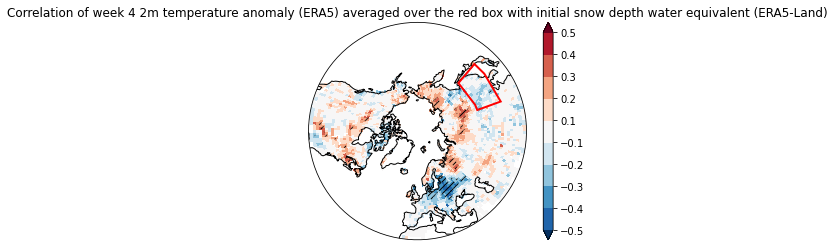

In [84]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
p=xs.pearson_r(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of week 4 2m temperature anomaly (ERA5) averaged over the red box with initial snow depth water equivalent (ERA5-Land)")

/home/ardilouzec/miniconda3/envs/climpred/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


Text(0.5, 1.0, 'Correlation of average 18 March-15 April 2m temperature anomaly (ERA5) averaged over the red box with average 17 Feb- 18 March snow depth water equivalent (ERA5-Land)')

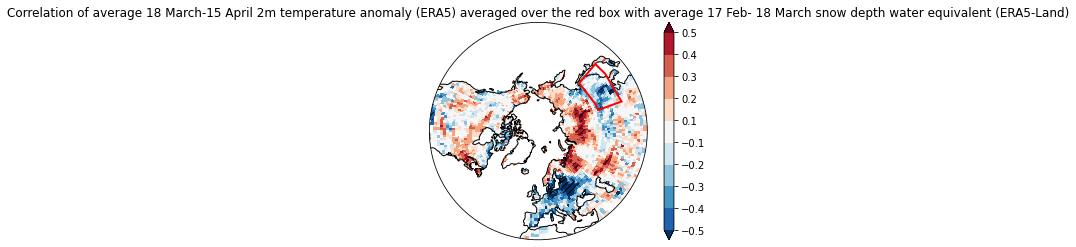

In [85]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
p=xs.pearson_r(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of average 18 March-15 April 2m temperature anomaly (ERA5) averaged over the red box with average 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")